In [32]:
import os
import sys
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [33]:
try:
    from xgboost import XGBClassifier
    has_xgb = True
except Exception:
    has_xgb = False

print('xgboost available:', has_xgb)

xgboost available: True


In [34]:
DATA_PATH = '../input/smoke-detection-dataset/smoke_detection.csv'

if os.path.exists(DATA_PATH):
    print('Found dataset at', DATA_PATH)
    df = pd.read_csv(DATA_PATH)
else:
    print('Dataset not found at', DATA_PATH)
    print('Generating a synthetic dataset as fallback (for demo only).')
    # Synthetic dataset: 10000 samples, features like temperature, humidity, co, lpg, methane
    rng = np.random.RandomState(42)
    n = 10000
    temperature = rng.normal(25, 5, size=n)
    humidity = rng.normal(40, 10, size=n)
    co = rng.exponential(0.5, size=n)
    lpg = rng.exponential(0.2, size=n)
    methane = rng.exponential(0.3, size=n)

Dataset not found at ../input/smoke-detection-dataset/smoke_detection.csv
Generating a synthetic dataset as fallback (for demo only).


In [35]:
    score = 0.02*(temperature-20) + 0.6*co + 0.8*lpg + 0.5*methane + rng.normal(0,0.2,size=n)
    prob = 1/(1+np.exp(-score))
    y = (prob > 0.85).astype(int)  # imbalanced, few positives
    df = pd.DataFrame({
        'temperature': temperature,
        'humidity': humidity,
        'co': co,
        'lpg': lpg,
        'methane': methane,
        'alarm': y
    })

print('Data shape:', df.shape)

Data shape: (10000, 6)


In [36]:
print(df.info())
print('\nMissing values per column:\n', df.isnull().sum())

# عرض بعض العينات
display(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   temperature  10000 non-null  float64
 1   humidity     10000 non-null  float64
 2   co           10000 non-null  float64
 3   lpg          10000 non-null  float64
 4   methane      10000 non-null  float64
 5   alarm        10000 non-null  int64  
dtypes: float64(5), int64(1)
memory usage: 468.9 KB
None

Missing values per column:
 temperature    0
humidity       0
co             0
lpg            0
methane        0
alarm          0
dtype: int64


,temperature,humidity,co,lpg,methane,alarm
0,27.483571,33.215053,0.028638,0.048889,0.174813,0
1,24.308678,36.945005,2.126117,0.519699,0.053234,1
2,28.238443,34.026189,0.804765,0.144651,0.283205,0
3,32.615149,41.104180,1.015551,0.131209,0.461980,0
4,23.829233,51.971785,0.592566,1.109566,0.329620,0


In [37]:
TARGET_COL = 'alarm'
if TARGET_COL not in df.columns:

    for candidate in ['Alarm', 'alarm', 'fire', 'Fire', 'target', 'label']:
        if candidate in df.columns:
            TARGET_COL = candidate
            break
    else:
        raise ValueError('Target column not found; عدّل TARGET_COL يدوياً في الكود')

X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL].astype(int)
print('Features:', X.columns.tolist())
print('Target distribution:\n', y.value_counts())

Features: ['temperature', 'humidity', 'co', 'lpg', 'methane']
Target distribution:
 alarm
0    9786
1     214
Name: count, dtype: int64


In [38]:
if X.isnull().any().any():
    print('Found missing values — filling with median per column')
    X = X.fillna(X.median())
else:
    print('No missing values found.')

No missing values found.


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
print('Train shape:', X_train.shape, 'Test shape:', X_test.shape)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Train shape: (8000, 5) Test shape: (2000, 5)


In [40]:
logreg = LogisticRegression(max_iter=1000, class_weight='balanced')
logreg.fit(X_train_scaled, y_train)

# تنبؤات
y_pred = logreg.predict(X_test_scaled)

# مقاييس الأداء
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred, zero_division=0)
rec = recall_score(y_test, y_pred, zero_division=0)
f1 = f1_score(y_test, y_pred, zero_division=0)

print('Logistic Regression Results:')
print(f'Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f}')
print('\nClassification report:\n', classification_report(y_test, y_pred, zero_division=0))

Logistic Regression Results:
Accuracy: 0.9585 | Precision: 0.3361 | Recall: 0.9535 | F1: 0.4970

Classification report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98      1957
           1       0.34      0.95      0.50        43

    accuracy                           0.96      2000
   macro avg       0.67      0.96      0.74      2000
weighted avg       0.98      0.96      0.97      2000



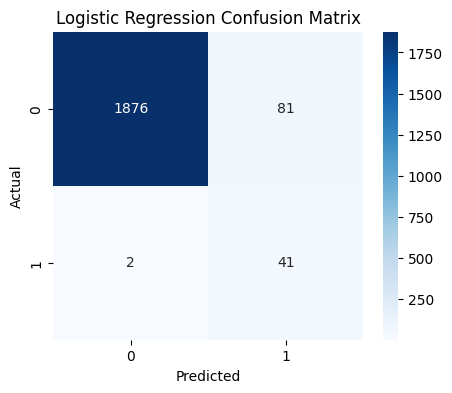

In [41]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Logistic Regression Confusion Matrix')
plt.show()


XGBoost Results:
Accuracy: 0.9855 | Precision: 0.7500 | Recall: 0.4884 | F1: 0.5915


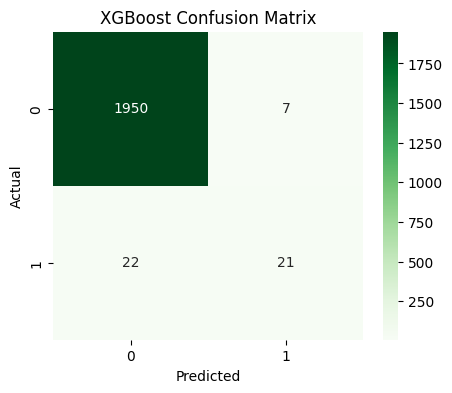


Comparison:
Recall Logistic: 0.9534883720930233  | Recall XGBoost: 0.4883720930232558
Logistic has higher recall in this run. Consider tuning hyperparameters or using resampling.


In [48]:
if has_xgb:
    xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
    xgb.fit(X_train, y_train)  # XGBoost لا يتطلب التحجيم بالضرورة
    y_pred_xgb = xgb.predict(X_test)
    acc_x = accuracy_score(y_test, y_pred_xgb)
    prec_x = precision_score(y_test, y_pred_xgb, zero_division=0)
    rec_x = recall_score(y_test, y_pred_xgb, zero_division=0)
    f1_x = f1_score(y_test, y_pred_xgb, zero_division=0)
    print('\nXGBoost Results:')
    print(f'Accuracy: {acc_x:.4f} | Precision: {prec_x:.4f} | Recall: {rec_x:.4f} | F1: {f1_x:.4f}')
    cm_x = confusion_matrix(y_test, y_pred_xgb)
    plt.figure(figsize=(5,4))
    ax = sns.heatmap(cm_x, annot=True, fmt='d', cmap='Greens')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    ax.set_title('XGBoost Confusion Matrix')
    plt.show()

    print('\nComparison:')
    print('Recall Logistic:', rec, ' | Recall XGBoost:', rec_x)
    if rec_x > rec:
        print('XGBoost achieves higher recall — desirable to reduce False Negatives in fire detection.')
    else:
        print('Logistic has higher recall in this run. Consider tuning hyperparameters or using resampling.')

else:
    print('\nXGBoost not available in this environment. On Kaggle, XGBoost is usually installed — enable it to run the bonus.')


In [50]:
print('النوتبوك جاهز للتشغيل والتحميل.')

النوتبوك جاهز للتشغيل والتحميل.
